# Optimisation du modèle
Dans ce notebook nous allons développer la démarche qui nous a conduit à selectionner le modèle intégré dans l'application Churn Predictor.


## Etape 1: Uploadez vos données

In [1]:
from churn_predictor.infrastructure.dataset import Dataset
import pandas as pd
import io
from ipywidgets import FileUpload, HBox, VBox, interact, interactive, fixed, interact_manual, interactive_output, BoundedIntText
from IPython.display import display


In [2]:
uploader_c = FileUpload(accept='.csv', multiple=False, description="customers.csv")
uploader_i = FileUpload(accept='.csv', multiple=False, description="indicators.csv")
box = HBox([uploader_c, uploader_i])
display(box)

In [3]:
if uploader_i.value.keys() and uploader_c.value.keys():
    df_c, df_i = (pd.read_csv(io.BytesIO(uploader.value[list(uploader.value.keys())[0]]["content"]), sep=";") for uploader in [uploader_c,uploader_i])
else:
    try:
        paths = ['../data/customers.csv', '../data/indicators.csv']
        df_c, df_i = (pd.read_csv(path, sep=";") for path in paths)
    except :   
        raise Exception('You need to provide your csv files before continuing')
df = df_c.merge(df_i,on="ID_CLIENT")
df

ID_CLIENT          DATE_ENTREE               NOM       PAYS SEXE  AGE  \
0      15688172  2015-01-01 00:00:00               Tai    Espagne    H   40   
1      15787258  2014-05-01 00:00:00              Ross    Espagne    F   29   
2      15791700  2018-01-01 00:00:00  Ugochukwutubelum  Allemagne    H   47   
3      15569438  2010-03-01 00:00:00               Mai  Allemagne    H   36   
4      15778947  2017-01-01 00:00:00          Sullivan     France    H   36   
...         ...                  ...               ...        ...  ...  ...   
9945   15711457  2013-01-01 00:00:00              Herz     France    F   28   
9946   15712403  2019-05-01 00:00:00          McMillan     France    F   61   
9947   15576263  2015-04-01 00:00:00          Clements     France    F   22   
9948   15745843  2016-02-01 00:00:00            Kinlaw    Espagne    F   31   
9949   15753229  2011-04-01 00:00:00          Genovese     France    H   29   

     MEMBRE_ACTIF    BALANCE  NB_PRODUITS CARTE_CREDIT    SALAIRE  \
0              No       0.00            2          Yes   88947.56   
1              No       0.00           16          Yes        NaN   
2             Yes  118079.47            4          Yes  143007.49   
3              No  106702.94            2           No  198313.69   
4             Yes       0.00            2          Yes    8742.91   
...           ...        ...          ...          ...        ...   
9945          Yes  124540.28            1           No  188850.89   
9946           No       0.00            1          Yes   61108.56   
9947           No       0.00            1          Yes   22303.17   
9948          Yes       0.00            2          Yes  136610.02   
9949          Yes  127414.55            1          Yes  134459.12   

      SCORE_CREDIT CHURN  
0            677.0    No  
1              NaN    No  
2            773.0   Yes  
3            607.0    No  
4            628.0    No  
...            ...   ...  
9945         755.0    No  
9946         589.0   Yes  
9947         759.0    No  
9948         689.0    No  
9949         802.0    No  

[9950 rows x 13 columns]

## Etape 2 - Définition des métriques de performances

L'objectif de l'algorithme est de détected le départ (churn) de client. Dans cette perspective il est émis l'hypothèse raisonnable que le client cherche, grace à cette prédiction à mettre en oeuvre une **action de prévention** de churn. Dans le cas où le `churn` n'est pas détecté ou que l'**action de prévention** n'aboutie pas, il a été émis l'hypothèse que l'impact économique de cette défailllance se mesurait à la hauteur du **coût d'acquisition** d'un nouveau client. 
Une alternative _non retenue_ pour le présent projet eut été de mesurer cette conséquence économique sur la base du **Manque à gagner** (cette alternative nécessite d'établir un model de revenu pour chaque profil de client et sa complexité de mise en oeuvre n'entrait pas dans le périmètre du présent projet).

Par ailleurs, cette objectif de prévision de départ introduit une hypothèse d'assymétrie de conséquence entre les classes. il est entendu par là que la prédiction correcte d'une personne labellisée `churn` n'a pas la même valeur économique qu'une personne labellisée `non churn`. Ce contexte nous a amené à prioriser une performance de prédiction en **Recall** et en **Précision** plutôt qu'en accuracy afin de développer un algorithme économiquement pertinant. 

Enfin il a été émis une dernière hypothèse d'assymétrie entre le **coût d'acquisition** d'un nouveau client et le **coût de l'action de prévention**. Cette hypothèse pénalise plus fortement les erreurs de `faux négatifs` ayant pour conséquence la perte d'un client au profit des erreurs de `faux positifs` qui n'impliquent ici qu'une démarche de sur-qualité de la relation client.

Il est important de noter comme nous le verrons plus bas qu'en fonction des écarts entre le cout d'acquisition client et le cout de l'action de prévention, l'intéret même de la démarche de prévision du churn peut être à considérer. 

Cette réflexion nous


In [4]:
from churn_predictor.interface.plots import plot_churn_cost_matrix
%matplotlib inline
style = {'description_width': 'initial'}
client_acquisition_cost = BoundedIntText(value = 100, min=0, max=1000, step=10, description="Client aquisition cost (€)",style=style)
churn_action_cost = BoundedIntText(value = 15, min=0, max=200, step=1, description="Churn action cost (€)", style=style)
churn_action_efficiency = BoundedIntText(value = 100,min=0, max=100,step=5, description="Churn action efficiency (%)", style=style)
churn_rate = BoundedIntText(value = 20,min=0, max=100,step=1, description="Churn rate (%)", style=style)
ui = VBox([client_acquisition_cost, churn_action_cost, churn_action_efficiency, churn_rate])

out = interactive_output(plot_churn_cost_matrix, {"client_acquisition_cost" : client_acquisition_cost, "churn_action_cost":churn_action_cost, "churn_action_efficiency":churn_action_efficiency, "churn_rate":churn_rate})
display(ui, out)

Output()

# Etape 3 : Exploration des modèles efficaces

Dans cette étape nous allons évaluer les performances des différents modèles de classification à notre disposition. 
Cette première recherche nous permettra d'isoler un candidat que nous allons ensuite chercher à perfectionner.
Une première évaluation exploratoire nous a permis d'établir un premier modèle extrếment simple permettant d'établir une référence pertinante à notre problème.
### Préparation des données

In [5]:
df["DATE_ENTREE"]=pd.to_datetime(df["DATE_ENTREE"]) 
df["ANNEE"] = df['DATE_ENTREE'].dt.year
df['MOIS'] = df['DATE_ENTREE'].dt.month
df = df.drop(['DATE_ENTREE', 'ID_CLIENT', 'NOM','CARTE_CREDIT'], axis=1)
df_used = df.dropna()
X = df_used.drop("CHURN", axis=1)
y = df_used["CHURN"].replace(to_replace=["Yes", "No"], value=[1,0])

## Evaluation de la baseline
Le modèle de classification que nous établissons comme baseline à notre benchmark repose sur la pipeline suivante 

 **Preprocessing**:
- Variables numériques
    - `StandardScaler`
- Variables catégorielles
    - `OneHotEncoder` 
    
**Classifier**:
- `SVC`

Notre instance `PipelineBenchmark` construit un environnement propice à l'évaluation comparée de modèle. Lors de son initialisation elle entraine et évalue la pipeline de baseline décrite plus haut. Elle sera plus tard référencée comme "Baseline classification"

In [6]:
from churn_predictor.domain.model_benchmark import PipelineBenchmark
from churn_predictor.interface.plots import plot_benchmark

bench = PipelineBenchmark(X, y)
bench.print_scores_of("Baseline classification")

Scores of Baseline classification
 - Churn_Cost: 13.78
 - Av_Prec: 0.66
 - ROC_AUC: 0.81
 - Recall: 0.41
 - Precision: 0.8


## 3.1 - Exploration des types de modèles

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


clf_names = ["Logistic Regression", "Nearest Neighbors", "Linear SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
]

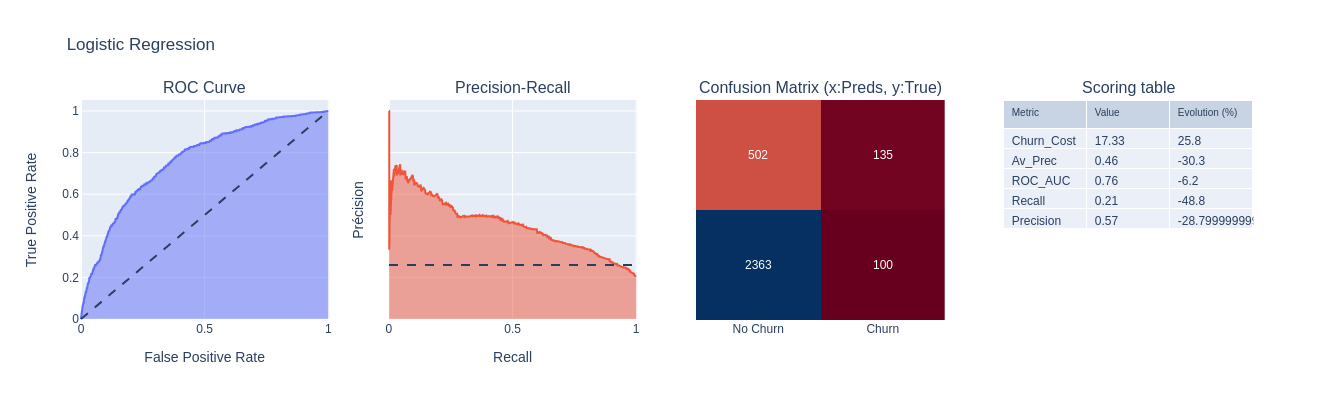

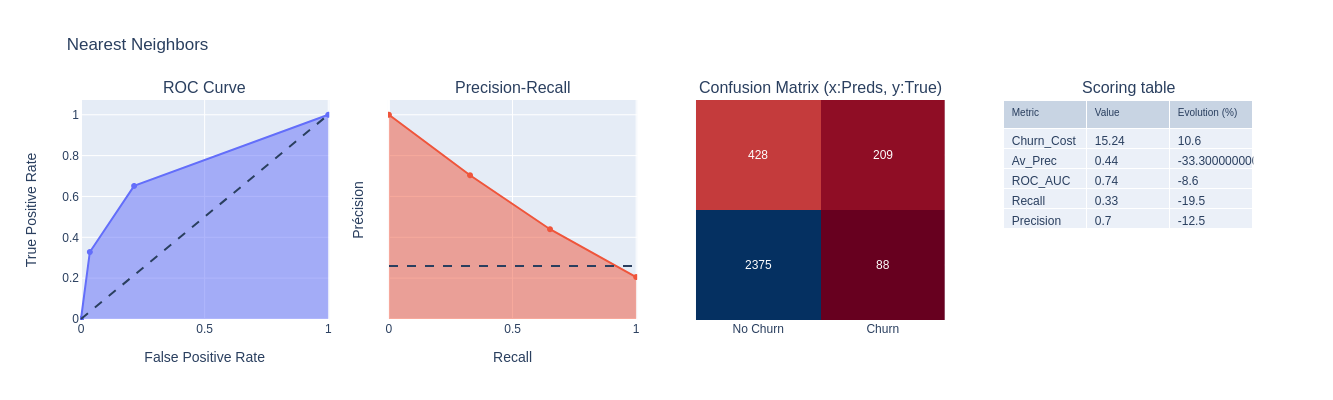

/home/antiez/code/projet_ml_advanced_am_mv_rh/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



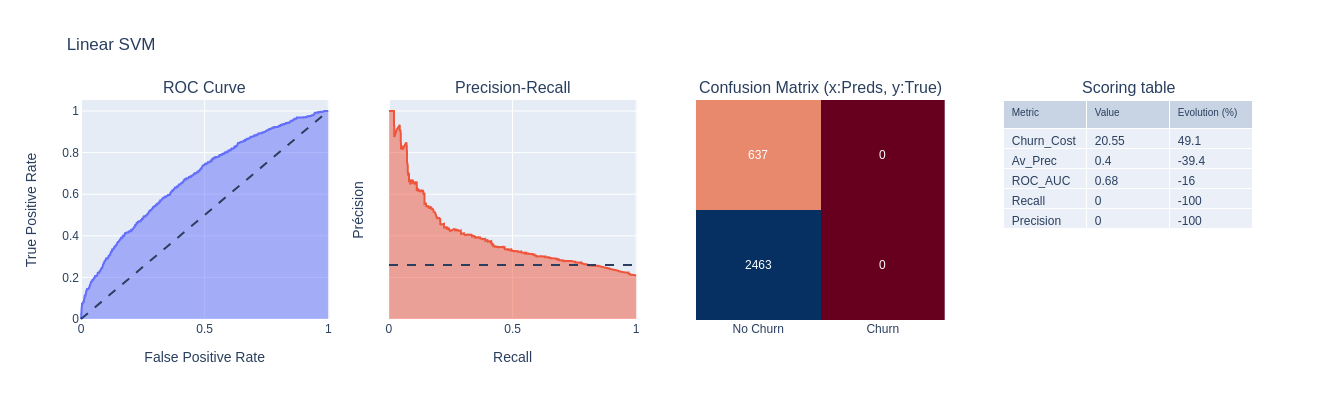

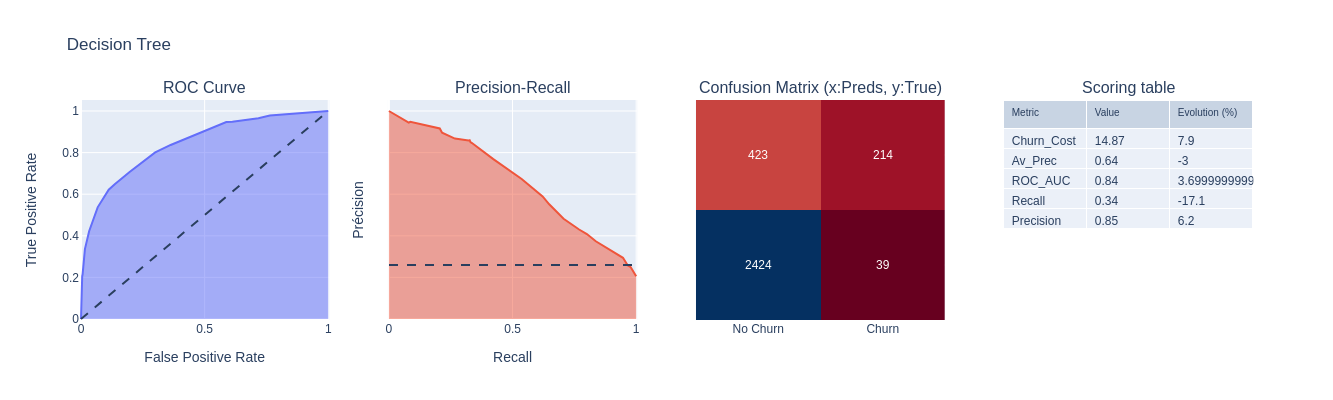

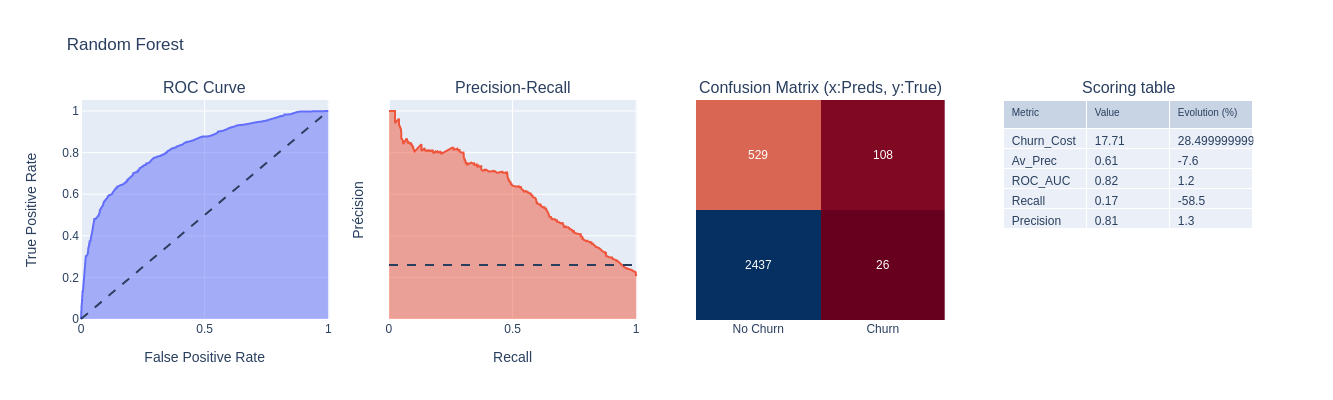

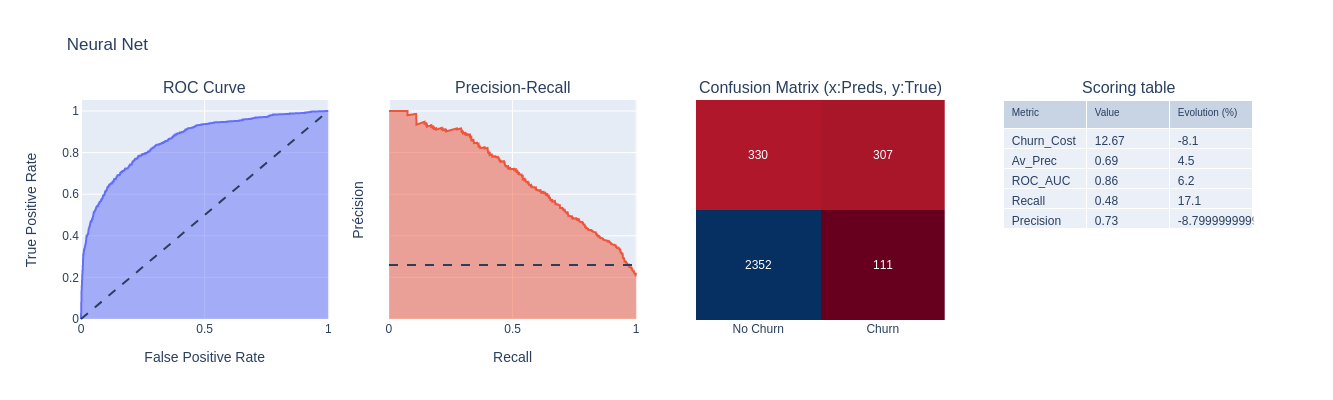

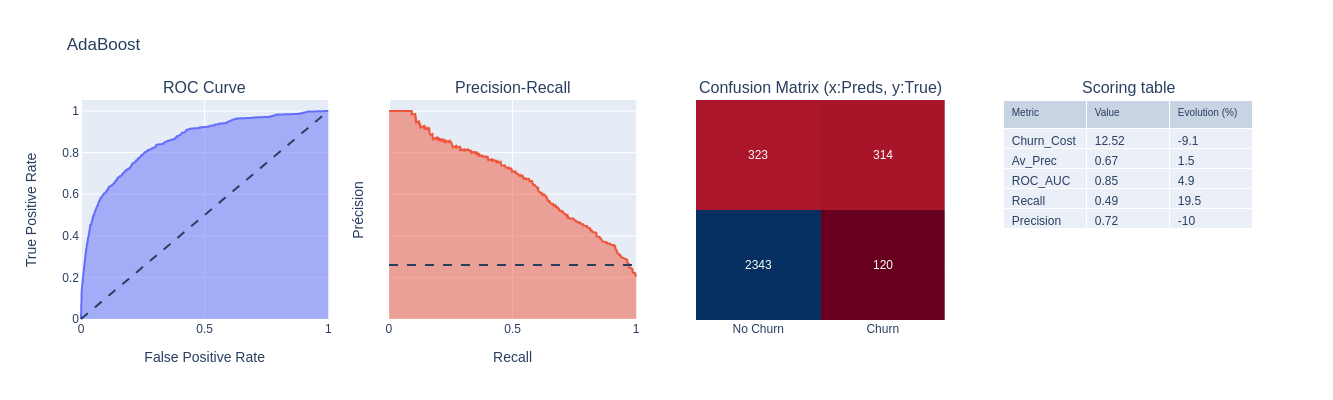

In [8]:

# iterate over the classifiers to test
for i, (name, clf) in enumerate(zip(clf_names, classifiers)):
    row = i+1                                
    pipeline = Pipeline( steps=[
        ('Preprocessor', bench.base_transformer),
        ('Model', clf),
    ])
    #Evaluate the model
    fpr_roc, tpr_roc, precision, recall, scores, conf_matrix = bench.evaluate(pipeline, name)
    #Plot the performance
    plot_benchmark(bench.y_test, name, fpr_roc, tpr_roc, precision, recall, scores, conf_matrix)


**Récapitulons nos résultats**

In [9]:
bench.palmares

--------------------------------------------------------------------------------
Palmares (top 5): Churn_Cost
   1 - AdaBoost: 12.52
   2 - Neural Net: 12.67
   3 - Baseline classification: 13.78
   4 - Decision Tree: 14.87
   5 - Nearest Neighbors: 15.24
--------------------------------------------------------------------------------
Palmares (top 5): Av_Prec
   1 - Neural Net: 0.69
   2 - AdaBoost: 0.67
   3 - Baseline classification: 0.66
   4 - Decision Tree: 0.64
   5 - Random Forest: 0.61
--------------------------------------------------------------------------------
Palmares (top 5): ROC_AUC
   1 - Neural Net: 0.86
   2 - AdaBoost: 0.85
   3 - Decision Tree: 0.84
   4 - Random Forest: 0.82
   5 - Baseline classification: 0.81
--------------------------------------------------------------------------------
Palmares (top 5): Recall
   1 - AdaBoost: 0.49
   2 - Neural Net: 0.48
   3 - Baseline classification: 0.41
   4 - Decision Tree: 0.34
   5 - Nearest Neighbors: 0.33
---------

**Conclusion**: Notre principale préoccupation dans ce projet est de maximiser la détection correcte des churners et minimizer le cout pour l'entreprise. 
Dans cette optique nous allons donc concentrer nos efforts sur le modèle qui offre les résultats les plus prométteurs, à savoir `AdaBoost`. 

__Note__: Le `Multilayer Perceptron` (Neural Net) a également obtenu de bonne performance sur notre problématique est il est important de noter que l'investigation du champs des Réseaux de neuronnes semble être une alternative pertinante si il advenait que les méthodes de boosting ne permettaient pas d'atteindre un niveau de performance suffisemment satisfaisant pour le client.

A ce stade du projet nous pouvons déjà évaluer l'économie envisageable :

In [10]:
saving_vs_active, saving_vs_passive = bench.savings_allowed_by('AdaBoost')
print("Economie réalisée pour chaque client")
print(f"- Si le client ne réalise actuellement aucune démarche de prévention: {saving_vs_passive}€")
print(f"- Si le client déploie une démarche de prévention sur l'ensemble de ses clients: {saving_vs_active}€")
print(f"Soit pour 100k clients une économique moyenne de {(saving_vs_passive+saving_vs_active)/2*100}k€")

Economie réalisée pour chaque client
- Si le client ne réalise actuellement aucune démarche de prévention: 7.48€
- Si le client déploie une démarche de prévention sur l'ensemble de ses clients: 2.4800000000000004€
Soit pour 100k clients une économique moyenne de 498.00000000000006k€


## C'est déjà très bien, mais peut-on faire mieux ?

## 3.2 Le preprocessing
Comme attendu la performance en recall est très significativement augmentée par les méthodes de resampling. Cela se fait néanmoins au dépend d'une baisse de l'accuracy et de la précision du système. Il est donc à interpréter que cette approche apportera plus de faux positifs, c'est à dire de personnes détectés Churners alors qu'elles ne le sont pas. Néanmoins nous obtenons désormais un gain de **25%** de notre capacité à détecter les personnes susceptibles de Churner et cela à un impact très important sur la rentabilité du modèle.

Il est temps désormais de remettre en cause notre approche du préprocessing. Nous avons jusqu'alors utilisé une approche simple quoi que robuste : `StandardScaler` pour les valeurs numériques, `OneHotEncoder` pour les variables catégorielles.
D'autres alternatives existent. Le travail que nous avons conduit dans le premier notebook nous amène à ensager une pipeline personnalisée constuire autour d'un principe de catégorisation de l'ensemble des variables (les détails techniques de cette pipeline sont présents dans sa documentation).
Par ailleurs nous pouvons également envisager d'autres alternatives plus standards.7

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OrdinalEncoder
from category_encoders import TargetEncoder
from churn_predictor.domain.preprocessing import Preprocessor

num_scalers = (MinMaxScaler(), RobustScaler())
cat_encoders =(OrdinalEncoder(), TargetEncoder())

numeric_features = ['AGE', 'BALANCE', 'NB_PRODUITS', "SCORE_CREDIT", ]
categorical_features = ['PAYS', 'SEXE', "MEMBRE_ACTIF"]

preprocessors = [Preprocessor]
names= ["CustomPrepro-Adaboost", "MinMax-Ordinal-UF-Adaboost","MinMax-Targer-UF-Adaboost","Robust-Ordinal-UF-Adaboost","MinMax-Target-UF-Adaboost"]

for scaler in num_scalers:
    for encoder in cat_encoders:
        """numeric_transformer = Pipeline(steps=[
            ('scaler', scaler)])

        categorical_transformer = Pipeline(steps=[
            ('onehot', encoder)])"""

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', scaler, numeric_features),
                ('cat', encoder, categorical_features)])
        preprocessors.append(preprocessor)

CustomPrepro-Adaboost


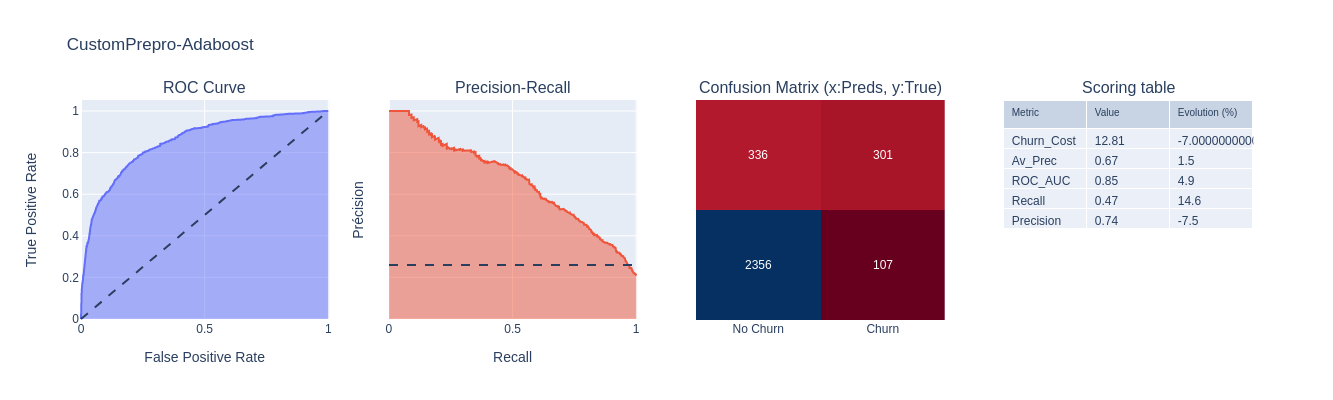

MinMax-Ordinal-UF-Adaboost


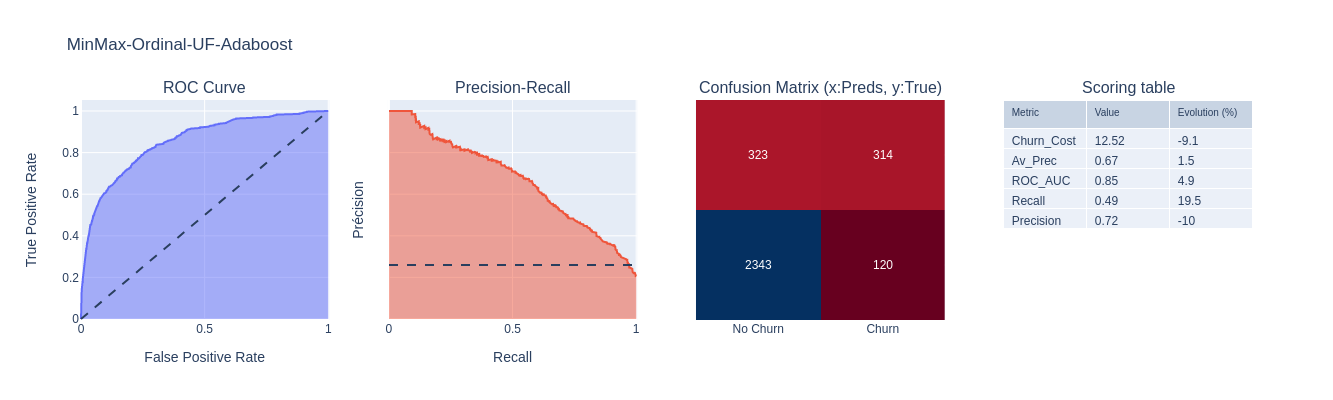

MinMax-Targer-UF-Adaboost


/home/antiez/code/projet_ml_advanced_am_mv_rh/.venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



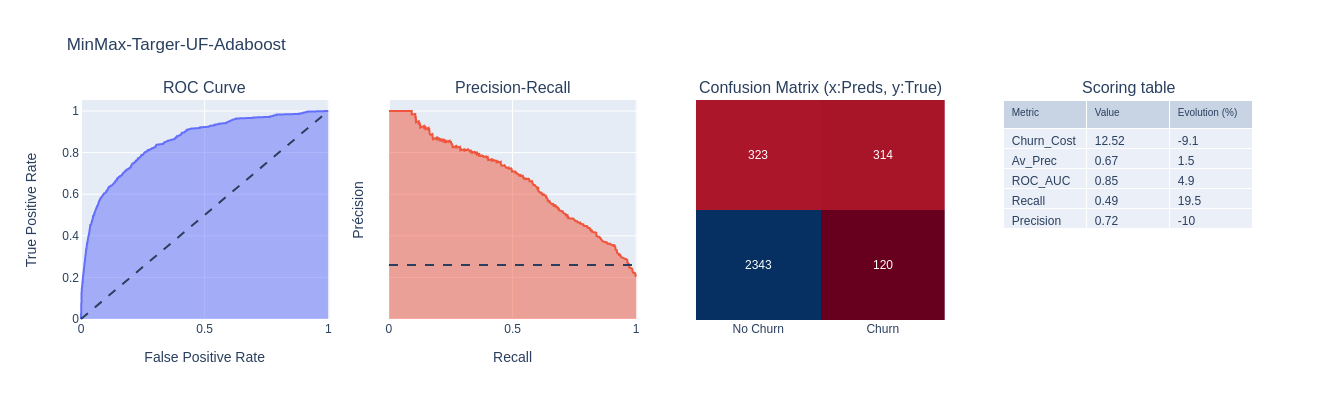

Robust-Ordinal-UF-Adaboost


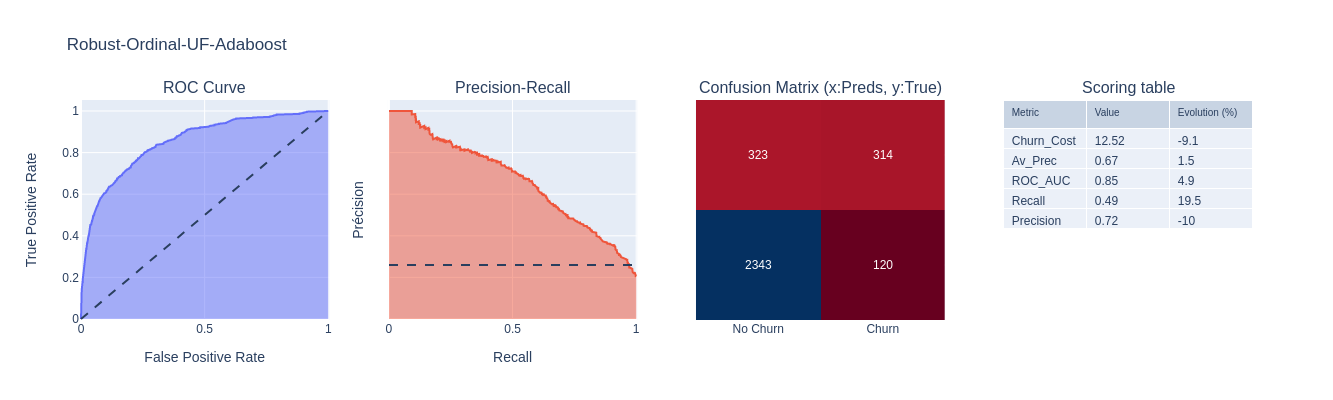

MinMax-Target-UF-Adaboost


/home/antiez/code/projet_ml_advanced_am_mv_rh/.venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



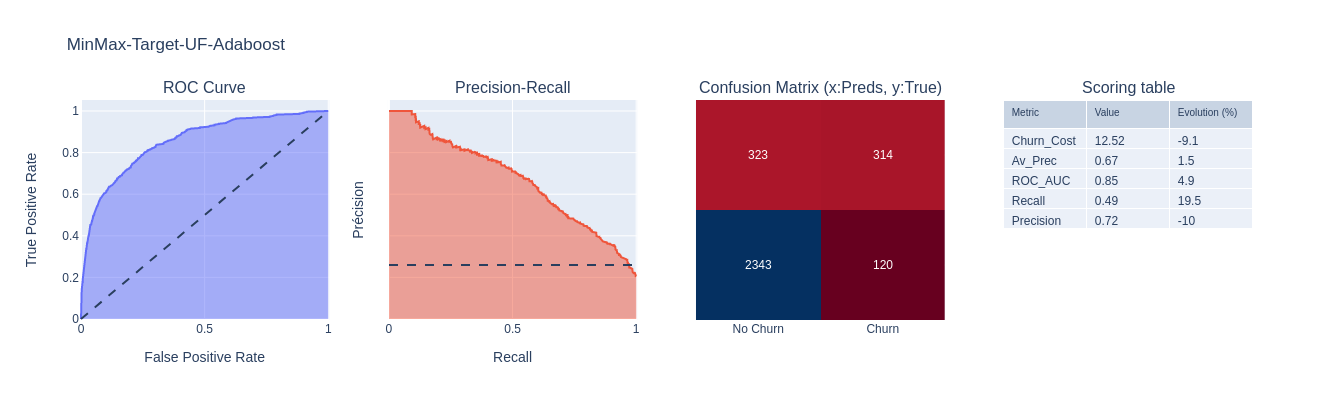

In [12]:
# iterate over the samplers to test
for (name, preprocessor) in zip(names, preprocessors):
    print(name)
    pipeline = Pipeline(steps=[
        ('Preprocessor', preprocessor),
        ('Model', AdaBoostClassifier()),
    ])
    #Evaluate the model
    fpr_roc, tpr_roc, precision, recall, scores , conf_matrix= bench.evaluate(pipeline, name)
    #Plot the performance
    plot_benchmark(bench.y_test, name, fpr_roc, tpr_roc, precision, recall, scores,conf_matrix)

Malheureusement Il semblerait le préprocessing custom ne permette pas d'améliorer les performances de l'Adaboost.
Par ailleurs les autres techniques d'encodage n'apportent pas non plus de gain à notre modèle. 

__note__: Pour des raisons de temps il ne nous a pas été possible de pousser plus loin les investigations sur le développement d'une pipeline de préprocessing custom. Nous sommes néanmoins percuadée que cette approche, poussée un peu plus loin, pourrait permettre des améliorations significatives de la performance.


## 3.3 Le rééchantillonage
Dans cette étape nous allons chercher à améliorer la performance de prédiction grace aux méthodes de sampling. Cette approche se justifie car nous sommes en présence d'un jeu de données ayant un fort déséquilibre de classe (1 churn pour 5 non churn)

In [13]:
 import imblearn

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

samplers = (SMOTE(random_state=42),
            RandomUnderSampler(random_state=42))
names = ["SMOTE_AdaBoost", "UnderSamp_Adaboost"]

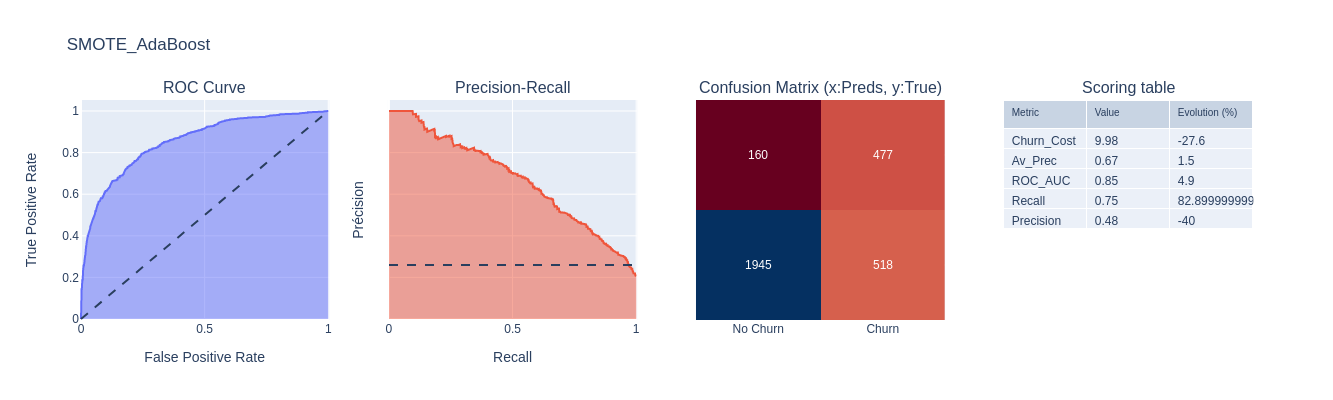

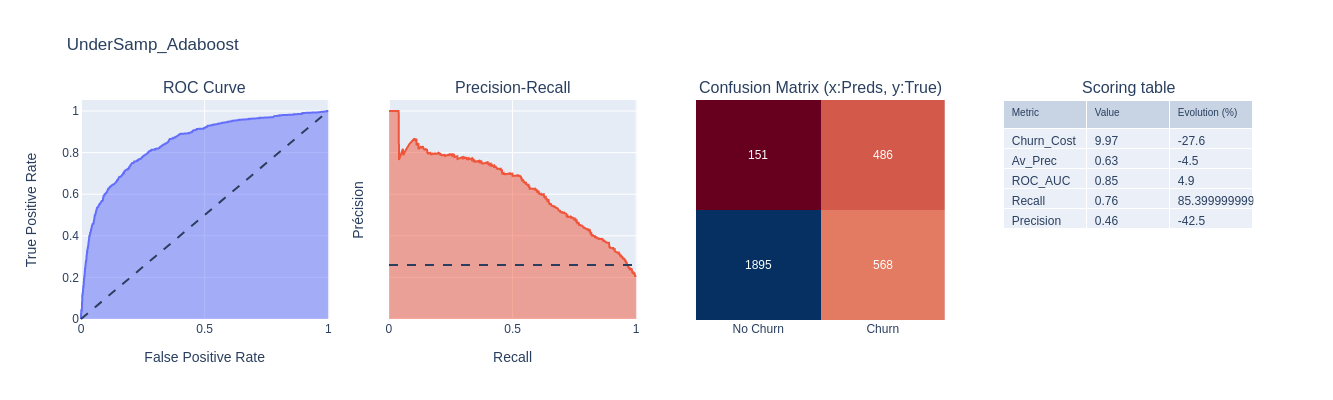

In [14]:
 # iterate over the samplers to test
for (name, samp) in zip(names, samplers):
    pipeline = imbPipeline(steps=[
        ('Preprocessor', bench.base_transformer),
        ('Sampler', samp),
        ('Model', AdaBoostClassifier()),
    ])
    #Evaluate the model
    fpr_roc, tpr_roc, precision, recall, scores , conf_matrix= bench.evaluate(pipeline, name)
    #Plot the performance
    plot_benchmark(bench.y_test, name, fpr_roc, tpr_roc, precision, recall, scores,conf_matrix)

In [15]:
bench.palmares

--------------------------------------------------------------------------------
Palmares (top 5): Churn_Cost
   1 - UnderSamp_Adaboost: 9.97
   2 - SMOTE_AdaBoost: 9.98
   3 - AdaBoost: 12.52
   4 - MinMax-Ordinal-UF-Adaboost: 12.52
   5 - MinMax-Targer-UF-Adaboost: 12.52
--------------------------------------------------------------------------------
Palmares (top 5): Av_Prec
   1 - Neural Net: 0.69
   2 - AdaBoost: 0.67
   3 - CustomPrepro-Adaboost: 0.67
   4 - MinMax-Ordinal-UF-Adaboost: 0.67
   5 - MinMax-Targer-UF-Adaboost: 0.67
--------------------------------------------------------------------------------
Palmares (top 5): ROC_AUC
   1 - Neural Net: 0.86
   2 - AdaBoost: 0.85
   3 - CustomPrepro-Adaboost: 0.85
   4 - MinMax-Ordinal-UF-Adaboost: 0.85
   5 - MinMax-Targer-UF-Adaboost: 0.85
--------------------------------------------------------------------------------
Palmares (top 5): Recall
   1 - UnderSamp_Adaboost: 0.76
   2 - SMOTE_AdaBoost: 0.75
   3 - AdaBoost: 0.49
   4

In [16]:
saving_vs_active, saving_vs_passive = bench.savings_allowed_by('UnderSamp_Adaboost')
print("Economies réalisées pour chaque client")
print(f"- Si le client ne réalise actuellement aucune démarche de prévention: {saving_vs_passive}€")
print(f"- Si le client déploie une démarche de prévention sur l'ensemble de ses clients: {saving_vs_active}€")
print(f"Soit pour 100k clients une économique moyenne de {round((saving_vs_passive+saving_vs_active)/2)*100}k€")

Economies réalisées pour chaque client
- Si le client ne réalise actuellement aucune démarche de prévention: 10.03€
- Si le client déploie une démarche de prévention sur l'ensemble de ses clients: 5.029999999999999€
Soit pour 100k clients une économique moyenne de 800k€




## 3.4 le tunning d'hyperparamètres.

Pour cette partie souvent délicate nous allons faire appel à une approche baysienne qui va nous permettre d'optimiser les ressources de calcul en se focalisant sur les hyperparamètres les plus impactants pour notre performance.
Afin d'éviter à notre système d'hypertuning de converger vers une solution trop simple nous allons lui demander d'optimiser sa précision moyenne en s'appuyant sur la meilleure pipeline conçue jusqu'alors.

In [17]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import numpy as np

pipeline = imbPipeline(steps=[
    ('Preprocessor', bench.base_transformer),
    ('Sampler', RandomUnderSampler(random_state=42)),
    ('classifier', AdaBoostClassifier()),
])

ITERATIONS = 40 
bases = [DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2),
        DecisionTreeClassifier(max_depth=3),
         DecisionTreeClassifier(max_depth=5),
         DecisionTreeClassifier(max_depth=8),
        ]

bayes_cv_tuner = BayesSearchCV(
    estimator = pipeline,
    search_spaces = {
        'classifier__learning_rate': (0.01, 1.0, 'log-uniform'),
        'classifier__n_estimators': (5, 5000, 'log-uniform'),
        'classifier__base_estimator':bases,
        'classifier__algorithm':['SAMME', 'SAMME.R'],
    }, 
    #scoring = churn_score_loss(),
    scoring = 'average_precision',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 3,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest score: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [18]:
from skopt.plots import plot_objective, plot_histogram

# Uncomment to perform the optimization again. (Warning: it is quite long)

#bayes_cv_tuner.fit(bench.X_train, bench.y_train,callback = status_print)
#_ = plot_objective(bayes_cv_tuner.optimizer_results_[0])

Après 100 itérations une solution optimale semble apparaitre avec un modèle AdaBoost construit sur les paramètres suivants :
- base_extimators: DecisionTreeClassifier(max_depth = 3)
- algorithm: SAMME
- n_estimators= 1000
- learning_rate= 0.1.


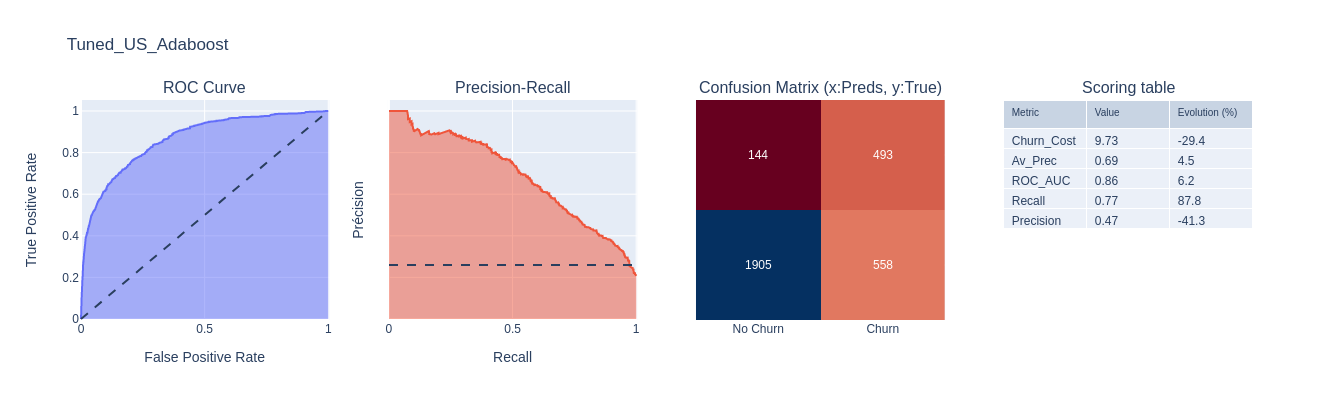

In [19]:
name = "Tuned_US_Adaboost"
pipeline = imbPipeline(steps=[
    ('Preprocessor', bench.base_transformer),
    ('Sampler', RandomUnderSampler(random_state=42)),
    ('classifier', AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=3),
        algorithm='SAMME',
        n_estimators= 1000,
        learning_rate= 0.1,
    )),
])
 #Evaluate the model
fpr_roc, tpr_roc, precision, recall, scores , conf_matrix= bench.evaluate(pipeline, name)
#Plot the performance
plot_benchmark(bench.y_test, name, fpr_roc, tpr_roc, precision, recall, scores,conf_matrix)

In [20]:
bench.palmares

--------------------------------------------------------------------------------
Palmares (top 5): Churn_Cost
   1 - Tuned_US_Adaboost: 9.73
   2 - UnderSamp_Adaboost: 9.97
   3 - SMOTE_AdaBoost: 9.98
   4 - AdaBoost: 12.52
   5 - MinMax-Ordinal-UF-Adaboost: 12.52
--------------------------------------------------------------------------------
Palmares (top 5): Av_Prec
   1 - Neural Net: 0.69
   2 - Tuned_US_Adaboost: 0.69
   3 - AdaBoost: 0.67
   4 - CustomPrepro-Adaboost: 0.67
   5 - MinMax-Ordinal-UF-Adaboost: 0.67
--------------------------------------------------------------------------------
Palmares (top 5): ROC_AUC
   1 - Neural Net: 0.86
   2 - Tuned_US_Adaboost: 0.86
   3 - AdaBoost: 0.85
   4 - CustomPrepro-Adaboost: 0.85
   5 - MinMax-Ordinal-UF-Adaboost: 0.85
--------------------------------------------------------------------------------
Palmares (top 5): Recall
   1 - Tuned_US_Adaboost: 0.77
   2 - UnderSamp_Adaboost: 0.76
   3 - SMOTE_AdaBoost: 0.75
   4 - AdaBoost: 0.4

## Le gain est léger mais l'économie significative. (270€ par tranche de 1000 clients)

### Nous avons donc un gagnant !


In [21]:
bench.print_scores_of("Tuned_US_Adaboost")

Scores of Tuned_US_Adaboost
 - Churn_Cost: 9.73
 - Av_Prec: 0.69
 - ROC_AUC: 0.86
 - Recall: 0.77
 - Precision: 0.47


In [22]:
saving_vs_active, saving_vs_passive = bench.savings_allowed_by('Tuned_US_Adaboost')
print("Economies réalisées pour chaque client")
print(f"- Si le client ne réalise actuellement aucune démarche de prévention: {saving_vs_passive}€")
print(f"- Si le client déploie une démarche de prévention sur l'ensemble de ses clients: {saving_vs_active}€")

Economies réalisées pour chaque client
- Si le client ne réalise actuellement aucune démarche de prévention: 10.27€
- Si le client déploie une démarche de prévention sur l'ensemble de ses clients: 5.27€


In [1]:
from churn_predictor.application.main import _train_model, predict
paths = ["customers.csv", "indicators.csv"]
res_path = _train_model(paths)
print(f" --- Pipeline saved in {res_path}")
preds = predict(paths)


________________________________________________________________________________
Pipeline performance: 0.7864713216957606. Initial perf: 0.85
________________________________________________________________________________
 --- Pipeline saved in /home/antiez/code/projet_ml_advanced_am_mv_rh/data/models/churn_classifer.joblib


9721

index             0
ID_CLIENT         0
DATE_ENTREE       0
NOM               0
PAYS              0
SEXE              0
AGE               0
MEMBRE_ACTIF      0
BALANCE           0
NB_PRODUITS       0
CARTE_CREDIT      0
SALAIRE           0
SCORE_CREDIT    330
CHURN             0
dtype: int64

 0    7697
-1    1535
 1     489
dtype: int64